In [1]:
import json
import numpy as np
import random
import sys
from tqdm import tqdm
import re

import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer

from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
import en_core_web_sm
nlp = en_core_web_sm.load()

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

#############################################################
from utils import get_triplets_by_idd, get_description_name

In [2]:
#path to full list of embeddings and full list of ids (one2one correspondence with embeddings)
PATH_TO_EMBEDDINGS = "../all_embeddings.npy" 
PATH_TO_IDS = "../all_entities.npy"

# pathes to training part of WikiData entity ids, their descriptions and embeddings(one2one correspondance)
PATH_TRAIN_DESCRIPTIONS = "../descriptions_0/descriptions10000.npy"
PATH_TRAIN_EMBEDDINGS = "../descriptions_0/embeddings10000.npy"
PATH_TRAIN_IDS = "../descriptions_0/ids10000.npy"

In [3]:
pretrained_weights = 'distilbert-base-uncased'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Preparing the data

In [4]:
descriptions = np.load(PATH_TRAIN_DESCRIPTIONS)
embeddings = np.load(PATH_TRAIN_EMBEDDINGS)
ids = np.load(PATH_TRAIN_IDS)

print(len(embeddings))
print(len(descriptions))

10000
10000


In [5]:
# train val split
N = 9000
descriptions_train = descriptions[:N]
descriptions_val = descriptions[N:]

graph_train = embeddings[:N]
graph_val = embeddings[N:]


In [6]:
# DistilBERT as an encoder

tokenizer = DistilBertTokenizer.from_pretrained(pretrained_weights)
class EncoderBERT(nn.Module):
    def __init__(self):
        super(EncoderBERT,self).__init__()
        self.encoder = DistilBertModel.from_pretrained(pretrained_weights).to(device)
    def forward(self,questions):
        q_ids = torch.tensor(questions)
        last_hidden_states = self.encoder(q_ids)[0]
        q_emb = torch.mean(last_hidden_states,dim=1)
        return q_emb
    
encoder = EncoderBERT().to(device)

In [7]:
# Trainable projection module

projection = nn.Sequential(
    nn.Linear(768,1024),
    nn.LeakyReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024,1024),
    nn.LeakyReLU(),
    nn.Linear(1024,512),
    nn.LeakyReLU(),
    nn.Linear(512,200)
).to(device).train()

In [11]:
# dataset class
MAX_LEN_Q = 32
class my_dataset(torch.utils.data.Dataset):
    def __init__(self, description, graph):
        self.description = description
        self.graph = graph
    def __len__(self):
        return len(self.description)
    def __getitem__ (self,i):
        input_ids = torch.tensor([tokenizer.encode(self.description[i], max_length=MAX_LEN_Q, add_special_tokens=True,pad_to_max_length=True)]).to(device)[0]
        graph_embedding = torch.FloatTensor(self.graph[i])
        return (input_ids.to(device),graph_embedding.to(device))
    
train_dataset = my_dataset(descriptions_train, graph_train)
train_batch_generator = torch.utils.data.DataLoader(train_dataset,batch_size=64, shuffle=True)

test_dataset = my_dataset(descriptions_val, graph_val)
test_batch_generator = torch.utils.data.DataLoader(test_dataset,batch_size=512, shuffle=True)

In [12]:
opt = torch.optim.Adam(projection.parameters())
opt_bert = torch.optim.Adam(encoder.parameters(),lr=0.0001)

### Training loop

In [13]:
losses = []
losses_test = []
cosines = []

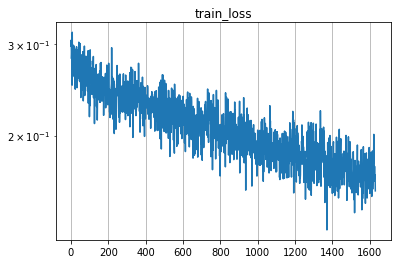

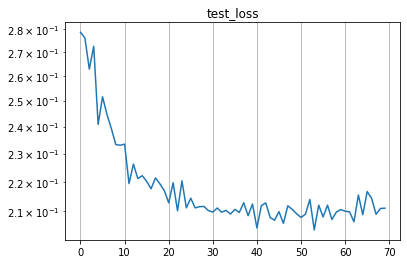

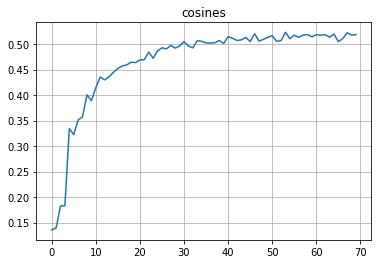

0.503 :    clinical psychology, integration of science and clinical knowledge for the purpose of relieving psychologically based dysfunction
0.498 :    A rating scale for depression, scientific article
0.483 :    An Inventory for Measuring Depression, scientific article
0.478 :    post-traumatic stress disorder, mental disorder that developed after experiencing or witnessing a terrifying or life-threatening event
0.475 :    General Hospital Psychiatry, journal


In [17]:
N_EPOCHS = 10
k = 0

for epoch in range(N_EPOCHS):
    for X, y in train_batch_generator:
        projection.train()
        y_pred = projection(encoder(X))
        loss = nn.MSELoss()(y,y_pred)
        losses.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        if k > 100:
            opt_bert.step()
        opt_bert.zero_grad()
        
        if k % 50 == 0:
            with torch.no_grad():
                for X, y in test_batch_generator:
                    y_pred = projection(encoder(X))
                    loss = nn.MSELoss()(y,y_pred)
                    losses_test.append(loss.item())
                    cosines.append(torch.mean(torch.cosine_similarity(y,y_pred)).item())
            plt.semilogy(losses)
            plt.grid()
            plt.title("train_loss")
            plt.show()
            
            plt.semilogy(losses_test)
            plt.grid()
            plt.title("test_loss")
            plt.show()
            
            plt.plot(cosines)
            plt.grid()
            plt.title("cosines")
            plt.show()
            projection.eval()
            text = "what is depression"
            X = torch.tensor([tokenizer.encode(text, max_length=MAX_LEN_Q, add_special_tokens=True,pad_to_max_length=True)]).to(device)[0].to(device)
            y_pred = projection(encoder(X[None,:]))

            embeddings_tensor = torch.FloatTensor(graph_train).to(device)
            cosines_test = torch.cosine_similarity(embeddings_tensor,y_pred)
            inds = torch.topk(cosines_test,5,sorted=True)
            for ind in inds.indices.cpu().detach().numpy():
#                 print(descriptions_train[ind])
                print(round(cosines_test[ind].item(),3),":   ",descriptions_train[ind])

            clear_output(wait=True)
        k += 1
        

### Triplet retrieval

In [18]:
embeddings = list(np.load(PATH_TO_EMBEDDINGS,allow_pickle=True))
embeddings_tensor = torch.FloatTensor(embeddings)
ids_list = list(np.load(PATH_TO_IDS,allow_pickle=True))

In [19]:
def get_top_ids(text,topk):
        projection.eval()
        bert_tokenize = lambda text: torch.tensor([tokenizer.encode(text, max_length=MAX_LEN_Q, add_special_tokens=True,pad_to_max_length=True)]).to(device)[0]
        X = torch.tensor([tokenizer.encode(text, max_length=MAX_LEN_Q, add_special_tokens=True,pad_to_max_length=True)]).to(device)[0].to(device)
        y_pred = projection(encoder(X[None,:]))
        cosines_descr = torch.cosine_similarity(embeddings_tensor.cpu(),y_pred.cpu())
        inds = torch.topk(cosines_descr,topk,sorted=True).indices.cpu().numpy()
        return np.array(ids_list)[inds], cosines_descr[inds]


In [20]:
def get_top_triplets(text,topk1,topk2):
    ids, cosines_descr = get_top_ids(text,topk1)
    duplets = []
    criterions = []
    inds_pairs = []
    for ind1,idd in enumerate(ids):
        triplets = get_triplets_by_idd(idd)
        d = [[t[1],t[2]] for t in triplets]
        duplets.append(d)
        bert_tokenize = lambda text: torch.tensor([tokenizer.encode(text, max_length=MAX_LEN_Q, add_special_tokens=True,pad_to_max_length=True)]).to(device)[0]
        X = torch.tensor([tokenizer.encode(text, max_length=MAX_LEN_Q, add_special_tokens=True,pad_to_max_length=True)]).to(device)[0].to(device)
        y_pred = projection(encoder(X[None,:])).cpu()
        
        d_embs = [projection(encoder(bert_tokenize(text[0] + ": " + text[1])[None,:])) for text in d]
        #####################################
        if len(d_embs) > 0:
            d_embs = torch.cat(d_embs).to(device)
            cosines_dup = torch.cosine_similarity(d_embs.to(device),y_pred.to(device))
            inds_dup = torch.topk(cosines_dup,len(cosines_dup),sorted=True)

            for ind2 in inds_dup.indices.cpu().detach().numpy():
                criterion = -(np.arccos(cosines_descr[ind1].item()) ** 2 + np.arccos(cosines_dup[ind2].item())) ** 2
                criterions.append(criterion.item())
                inds_pairs.append([ind1,ind2])

    indices = torch.topk(torch.tensor(criterions),topk2,sorted=True).indices
    out = []
    for i, ind in enumerate(indices):
        inds = inds_pairs[ind]
        out.append(f"# {i + 1}")
        out.append("criterion:"+ str(round(criterions[ind],4)))
        out.append(str(get_description_name(ids[inds[0]])))
        out.append(str(duplets[inds[0]][inds[1]]))

    return out
        
        

In [22]:
topk1 = 20
topk2 = 10
text = "what is depression"
get_top_triplets(text,topk1,topk2)


/home/razzhigaev/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


['# 1',
 'criterion:-2.3934',
 'dysthymic disorder, mood disorder that involves the presence of a low mood almost daily over a span of at least two years',
 "['subclass of', 'mood disorder']",
 '# 2',
 'criterion:-2.4512',
 'dysthymic disorder, mood disorder that involves the presence of a low mood almost daily over a span of at least two years',
 "['different from', 'schizoid personality disorder']",
 '# 3',
 'criterion:-2.547',
 'obsessive-compulsive personality disorder, personal perfectionism at the cost of flexibility, openness, efficiency & effect on others',
 "['subclass of', 'personality disorder']",
 '# 4',
 'criterion:-2.6583',
 'hopelessness, lack of hope',
 "['instance of', 'mental state']",
 '# 5',
 'criterion:-2.6644',
 'dysthymic disorder, mood disorder that involves the presence of a low mood almost daily over a span of at least two years',
 "['health specialty', 'psychiatry']",
 '# 6',
 'criterion:-2.7302',
 'post-traumatic stress disorder, mental disorder that develop

In [23]:
topk1 = 20
topk2 = 10

text = "treatment for depression"
get_top_triplets(text,topk1,topk2)


/home/razzhigaev/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


['# 1',
 'criterion:-1.8496',
 'post-traumatic stress disorder, mental disorder that developed after experiencing or witnessing a terrifying or life-threatening event',
 "['different from', 'acute stress disorder']",
 '# 2',
 'criterion:-1.9389',
 'dysthymic disorder, mood disorder that involves the presence of a low mood almost daily over a span of at least two years',
 "['subclass of', 'mood disorder']",
 '# 3',
 'criterion:-1.9576',
 'dysthymic disorder, mood disorder that involves the presence of a low mood almost daily over a span of at least two years',
 "['health specialty', 'psychiatry']",
 '# 4',
 'criterion:-2.0178',
 'dysthymic disorder, mood disorder that involves the presence of a low mood almost daily over a span of at least two years',
 "['possible treatment', 'psychotherapy']",
 '# 5',
 'criterion:-2.1502',
 'post-traumatic stress disorder, mental disorder that developed after experiencing or witnessing a terrifying or life-threatening event',
 "['subclass of', 'anxiety